<a href="https://colab.research.google.com/github/movie112/INU-DILAB/blob/main/210811_210824/popcorn_kaggle2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bag of Words Meets Bags of Popcorn
### Use Google's Word2Vec for movie reviews
<https://www.kaggle.com/c/word2vec-nlp-tutorial/overview>
- 영화 사이트 IMDB 영화 리뷰 데이터셋 이용
- 리뷰 긍정 1 부정 0 으로 표시
- files
  - labeldTrainData: 라벨링된 트레이닝 셋. 내용은 tab으로 구분되며 id, sentiment, review로 구성
  - testData: id, review 구성. 모델을 트레이닝할 때 테스트셋으로 사용하라는 것이 아니라 최종적으로 이 데이터셋을 이용하여 판단한다는 의미로 보임(unlabeled)
  - unlabeledTrainData: 라벨링되지 않은 트레이닝 셋
  - sampleSubmission: 제출 포맷
- word2vec, randomforest
- 참고
  - <https://nlp.gitbook.io/book/tf-with-kaggle/untitled/bag-of-words-meets-bags-of-popcorn/word2vec>
  - <https://www.kaggle.com/harshitmakkar/nlp-word2vec>

---

## 라이브러리

In [ ]:
import pandas as pd
import numpy as np
import os
import csv
import seaborn as sns

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from bs4 import BeautifulSoup
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 데이터
- Word2Vec은 unlabeled 데이터를 사용해서 학습할 수 있으므로, 이제 50,000개의 리뷰를 추가적으로 사용할 수 있다.

In [ ]:
# Read data from files
train = pd.read_csv( "/content/drive/MyDrive/movie-review/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )
test = pd.read_csv( "/content/drive/MyDrive/movie-review/testData.tsv", header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv( "/content/drive/MyDrive/movie-review/unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )

# Verify the number of reviews that were read (100,000 in total)
print("Read {0} labeled train reviews, {1} labeled test reviews, and {2} unlabeled reviews\n"\
      .format(train["review"].size,  test["review"].size, unlabeled_train["review"].size ))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



In [ ]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [ ]:
train['review'][0][:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

##### 흔히 쓰이는 단어
- HTML 태그가 흔히 쓰인다.

('the', 286998) a


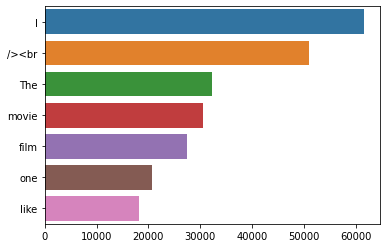

In [ ]:
corpus=[] 
for x in train['review'].str.split():
  for i in x:
    corpus.append(i)
counter = Counter(corpus)

most = counter.most_common()
print(most[0], most[1][0][0]) # 빈도, 문자열만 추출

x =[]
y =[]

for word, count in most[:40]:
  if(word not in set(stopwords.words('english'))):   
    x.append(word)
    y.append(count)

sns.barplot(x=y,y=x)

---

## Data Cleaning

#### 전처리 함수
- Word2Vec는 문장의 문맥(context)을 고려하여 하이퀄리티 단어 벡터를 생성하기 때문에, stop word를 제거하는 것이 안 좋을 수 있다. 따라서 아래 함수에서 stop word 제거를 옵셔널하게 바꾸었다. 마찬가지의 이유로 숫자도 남겨두는 것이 더 좋을 수도 있다.

In [ ]:
# Import various modules for string cleaning
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

def review_to_wordlist( review, remove_stopwords=False ):
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters -> 공백
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return words

#### Tokenization function
- input format을 맞추어야 한다. Word2Vec은 각 문장이 단어 list로 구성된 list를 input으로 받는다. 즉, input format은 2중 list 구조
- 문단(paragraph)을 문장(sentence)으로 나누는 것은 간단한 작업이 아니다. 자연어(natural language)에는 수많은 변수들이 존재한다. 영어 문장은 “?”, “!”, “”“, “.” 등 다양한 문자로 끝날 수 있고, 띄어쓰기나 대문자는 별로 신뢰할만한 기준이 되지 못한다. 이러한 이유로, 문장 분리를 위해 NLTK의 punkt tokenizer를 사용한다.

In [ ]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words, so this returns a list of lists
    return sentences

#### data cleaning

In [ ]:
sentences = []  # Initialize an empty list of sentences

print("Parsing sentences from training set")
for i, review in enumerate(train["review"]):
    if (i+1) % 1000 == 0:
        print("[training set] {} of {}".format(i+1, train["review"].size))
    sentences += review_to_sentences(review, tokenizer)

print("Parsing sentences from unlabeled set")
for i, review in enumerate(unlabeled_train["review"]):
    if (i+1) % 1000 == 0:
        print("[unlabeled set] {} of {}".format(i+1, unlabeled_train["review"].size))
    sentences += review_to_sentences(review, tokenizer)

Parsing sentences from training set


/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


[training set] 1000 of 25000


/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


[training set] 2000 of 25000
[training set] 3000 of 25000
[training set] 4000 of 25000
[training set] 5000 of 25000
[training set] 6000 of 25000
[training set] 7000 of 25000
[training set] 8000 of 25000
[training set] 9000 of 25000
[training set] 10000 of 25000
[training set] 11000 of 25000
[training set] 12000 of 25000
[training set] 13000 of 25000
[training set] 14000 of 25000
[training set] 15000 of 25000
[training set] 16000 of 25000
[training set] 17000 of 25000
[training set] 18000 of 25000
[training set] 19000 of 25000
[training set] 20000 of 25000
[training set] 21000 of 25000
[training set] 22000 of 25000
[training set] 23000 of 25000
[training set] 24000 of 25000
[training set] 25000 of 25000
Parsing sentences from unlabeled set


/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.archive.org/details/LovefromaStranger"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


[unlabeled set] 1000 of 50000
[unlabeled set] 2000 of 50000


/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.loosechangeguide.com/LooseChangeGuide.html"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


[unlabeled set] 3000 of 50000
[unlabeled set] 4000 of 50000
[unlabeled set] 5000 of 50000
[unlabeled set] 6000 of 50000
[unlabeled set] 7000 of 50000
[unlabeled set] 8000 of 50000
[unlabeled set] 9000 of 50000
[unlabeled set] 10000 of 50000
[unlabeled set] 11000 of 50000
[unlabeled set] 12000 of 50000
[unlabeled set] 13000 of 50000
[unlabeled set] 14000 of 50000
[unlabeled set] 15000 of 50000
[unlabeled set] 16000 of 50000
[unlabeled set] 17000 of 50000
[unlabeled set] 18000 of 50000
[unlabeled set] 19000 of 50000
[unlabeled set] 20000 of 50000
[unlabeled set] 21000 of 50000


/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.msnbc.msn.com/id/4972055/site/newsweek/"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


[unlabeled set] 22000 of 50000
[unlabeled set] 23000 of 50000
[unlabeled set] 24000 of 50000
[unlabeled set] 25000 of 50000
[unlabeled set] 26000 of 50000
[unlabeled set] 27000 of 50000
[unlabeled set] 28000 of 50000
[unlabeled set] 29000 of 50000
[unlabeled set] 30000 of 50000
[unlabeled set] 31000 of 50000


/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


[unlabeled set] 32000 of 50000
[unlabeled set] 33000 of 50000
[unlabeled set] 34000 of 50000
[unlabeled set] 35000 of 50000


/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.youtube.com/watch?v=a0KSqelmgN8"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


[unlabeled set] 36000 of 50000
[unlabeled set] 37000 of 50000
[unlabeled set] 38000 of 50000
[unlabeled set] 39000 of 50000
[unlabeled set] 40000 of 50000
[unlabeled set] 41000 of 50000
[unlabeled set] 42000 of 50000
[unlabeled set] 43000 of 50000
[unlabeled set] 44000 of 50000
[unlabeled set] 45000 of 50000
[unlabeled set] 46000 of 50000
[unlabeled set] 47000 of 50000
[unlabeled set] 48000 of 50000


/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://jake-weird.blogspot.com/2007/08/beneath.html"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


[unlabeled set] 49000 of 50000
[unlabeled set] 50000 of 50000


In [ ]:
print(sentences[0])

['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again']


## Training and Saving Model
- 모델을 학습할 준비가 되었다. 실행시간과 최종 모델의 정확도에 영향을 끼치는 파라메터들의 값을 선택해야 한다.
> - Architecture: 아키텍처 옵션은 skip-gram (default) 와 continuous bag of words가 있다. skip-gram이 미세하게 느리지만 더 좋은 결과를 보여준다.
Training algorithm: hierarchical softmax (default) 와 negative sampling이 있다. 여기서는, 디폴트가 좋다.
> - Downsampling of frequent words: 구글 도큐먼트에서 .00001에서 .001 사이의 값을 추천한다. 여기서는, 0.001에 가까운 값이 좋아 보인다.
> - Word vector dimensionality: 많은 특성(feature)은 더 많은 학습시간을 요구하지만, 보통 더 좋은 결과를 낸다(항상 그런것은 아니다). 수십에서 수백 정도가 적당한 값이다; 우리는 300개의 특성을 사용한다.;
> - Context / window size: word2vec은 어떤 단어 주변의 단어들, 즉 문맥을 고려해서 해당 단어의 의미를 파악한다. 이 때 얼마나 많은 단어를 고려해야 할까? 10 정도가 hierarchical softmax에 적당하다. 이 값도 어느정도까지는 높을수록 좋다.
> - Worker threads: 패러렐 쓰레드의 수. 컴퓨터마다 다르겠지만, 일반적으로 4~6 정도가 적당하다.
> - Minimum word count: meaningful word를 규정하는 최소 word count. 이 수치 미만으로 등장하는 단어는 무시한다. 10에서 100 사이의 값이 적당하다. 우리의 경우, 각 영화가 30번씩 등장하므로, 영화 제목에 너무 많은 의미 부여를 피하기 위해 minimum word count를 40으로 설정하였다. 그 결과로 vocabulary size는 약 15,000개의 단어다.

맨 앞, sentences는 학습시킬 문장을 입력합니다.   
workers : 실행할 병렬 프로세스의 수, 코어수, 주로 4-6사이 지정   
size : 각 단어에 대한 임베딩 된 벡터차원 정의, size=2라면 한 문장의 벡터는 [-0.1248574, 0.255778]와 같은 형태를 가지게 된다.   
min_count : 단어에 대한 최소 빈도수. min_count=5라면 빈도수 5 이하 무시   
window : 문맥 윈도우 수, 양쪽으로 몇 개의 단어까지 고려해서 의미를 파악할 것인지 지정하는 것   
sample : 빠른 학습을 위해 정답 단어 라벨에 대한 다운샘플링 비율을 지정하는 것, 보통 0.001이 좋은 성능을 낸다고 한다.   
sg : 1이면 skip-gram 방법을 사용하고, 0이면 CBOW 방법을 사용한다.   
iter : epoch와 같은 뜻으로 학습 반복 횟수를 지정한다.
<https://ebbnflow.tistory.com/153>

In [ ]:
# Import the built-in logging module and configure it so that Word2Vec
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality
min_word_count = 40   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

## Model Result
- “doesnt_match” 함수는 주어진 단어 셋(set) 중에서 가장 비슷하지 않은 단어를 추정한다

In [ ]:
model.doesnt_match("man women child kitchen".split())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'kitchen'

우리 모델이 이 의미 차이를 구분해낸다! man, women, children이 비슷하고 kitchen과는 다르다는 것을 알고 있다. 이제 도시와 나라같은 미묘한 차이도 구분하는지 확인해 보자:

In [ ]:
model.doesnt_match("france england germany berlin".split())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'berlin'

In [ ]:
model.most_similar("man")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('woman', 0.6267052888870239),
 ('lady', 0.5899450182914734),
 ('lad', 0.5555330514907837),
 ('monk', 0.5424312353134155),
 ('chap', 0.533638596534729),
 ('guy', 0.5276709794998169),
 ('soldier', 0.5261393785476685),
 ('millionaire', 0.5131581425666809),
 ('men', 0.5098788738250732),
 ('businessman', 0.5097929239273071)]

또는, 감정분석을 위해서는 이런 걸 찾아보자.

In [ ]:
model.most_similar("awful")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('terrible', 0.7765267491340637),
 ('horrible', 0.7447943687438965),
 ('atrocious', 0.7402299046516418),
 ('abysmal', 0.7181999683380127),
 ('dreadful', 0.6820523738861084),
 ('horrendous', 0.6772993803024292),
 ('horrid', 0.6707334518432617),
 ('appalling', 0.6601128578186035),
 ('lousy', 0.6226420402526855),
 ('laughable', 0.6196815371513367)]

IMDB 데이터셋의 한 가지 문제는 리뷰의 길이가 변한다는 것이다. 우리는 여기서 각각의 단어 벡터들을 각 리뷰를 나타내는 동일한 크기의 특성 셋으로 나타내어야 한다.
모든 단어들이 전부 300차원 벡터이므로, 간단하게 각 리뷰의 벡터들을 평균 내는 방법을 사용할 수 있다 (이를 위해 stop word를 제거했다. 이러한 경우에 stop word는 노이즈가 된다).
아래 코드들은 벡터들을 평균내는 함수다:

In [ ]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    #
    # Index2word is a list that contains the names of the words in
    # the model's vocabulary. Convert it to a set, for speed
    index2word_set = set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    #
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

    #
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate
    # the average feature vector for each one and return a 2D numpy array
    #
    # Initialize a counter
    counter = 0.
    #
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    #
    # Loop through the reviews
    for review in reviews:
       #
       # Print a status message every 1000th review
       if counter%1000. == 0.:
           print("Review %d of %d" % (counter, len(reviews)))
       #
       # Call the function (defined above) that makes average feature vectors
       reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, \
           num_features)
       #
       # Increment the counter
       counter = counter + 1.
    return reviewFeatureVecs

이제 이 함수로 각 리뷰에 대한 평균 벡터를 구할 수 있다.

In [ ]:
clean_train_reviews = []
for c, review in enumerate(train["review"]):
    if c%1000. == 0.:
        print("Training set {} of {}".format(c, train.shape[0]))
    clean_train_reviews.append( review_to_wordlist( review, remove_stopwords=True ))

trainDataVecs = getAvgFeatureVecs( clean_train_reviews, model, num_features )

print("Creating average feature vecs for test reviews")
clean_test_reviews = []
for c, review in enumerate(test["review"]):
    if c%1000. == 0.:
        print("Test set {} of {}".format(c, test.shape[0]))
    clean_test_reviews.append( review_to_wordlist( review, remove_stopwords=True ))

testDataVecs = getAvgFeatureVecs( clean_test_reviews, model, num_features )

Training set 0 of 25000
Training set 1000 of 25000
Training set 2000 of 25000
Training set 3000 of 25000
Training set 4000 of 25000
Training set 5000 of 25000
Training set 6000 of 25000
Training set 7000 of 25000
Training set 8000 of 25000
Training set 9000 of 25000
Training set 10000 of 25000
Training set 11000 of 25000
Training set 12000 of 25000
Training set 13000 of 25000
Training set 14000 of 25000
Training set 15000 of 25000
Training set 16000 of 25000
Training set 17000 of 25000
Training set 18000 of 25000
Training set 19000 of 25000
Training set 20000 of 25000
Training set 21000 of 25000
Training set 22000 of 25000
Training set 23000 of 25000
Training set 24000 of 25000
Review 0 of 25000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Creating average feature vecs for test reviews
Test set 0 of 25000
Test set 1000 of 25000
Test set 2000 of 25000
Test set 3000 of 25000
Test set 4000 of 25000
Test set 5000 of 25000
Test set 6000 of 25000
Test set 7000 of 25000
Test set 8000 of 25000
Test set 9000 of 25000
Test set 10000 of 25000
Test set 11000 of 25000
Test set 12000 of 25000
Test set 13000 of 25000
Test set 14000 of 25000
Test set 15000 of 25000
Test set 16000 of 25000
Test set 17000 of 25000
Test set 18000 

주석으로 설명이 적혀 있지만, 간단히 설명하자면 makeFeatureVec은 리뷰 파라그래프를 받아서 각 단어들에 대해 model이 포함하는 단어인지 검사하여 평균을 구한다. 즉, 특정 리뷰에 대해 특성 벡터를 구하는 함수이고 getAvgFeatureVecs는 모든 리뷰에 대해 makeFeatureVec함수를 적용하여 특성 벡터 리스트를 구하는 함수다.
자, 그럼 이제 각 리뷰들의 특성 벡터를 추출하였으니 이 값으로 머신러닝 알고리즘을 돌릴 수 있다. Bag of Words에서 했던 것처럼 랜덤 포레스트를 적용해 보자.

In [ ]:
# Fit a random forest to the training data, using 100 trees
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( n_estimators = 100 )

print("Fitting a random forest to labeled training data...")
forest = forest.fit( trainDataVecs, train["sentiment"] )

# Test & extract results
result = forest.predict( testDataVecs )

# Write the test results
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv( "Word2Vec_AverageVectors.csv", index=False, quoting=3 )

Fitting a random forest to labeled training data...
